In [1]:
import numpy as np
import tensorflow as tf
from unet import unet
import matplotlib.pylab as plt
from data_generator import DataGeneratorUnet 
import glob
from utils import dice_coef_loss, dice_coef

In [2]:
imgs_list_train = glob.glob("C:/Users/rober/OneDrive/Documents/GitHub/ENSF619.2/SLURM/Unet-Segmentation/Data-preprocessed/Train/Images/*.npy")
masks_list_train = glob.glob("C:/Users/rober/OneDrive/Documents/GitHub/ENSF619.2/SLURM/Unet-Segmentation/Data-preprocessed/Train/Masks/*.npy")
imgs_list_val = glob.glob("C:/Users/rober/OneDrive/Documents/GitHub/ENSF619.2/SLURM/Unet-Segmentation/Data-preprocessed/Val/Images/*.npy")
masks_list_val = glob.glob("C:/Users/rober/OneDrive/Documents/GitHub/ENSF619.2/SLURM/Unet-Segmentation/Data-preprocessed/Val/Masks/*.npy") 

In [3]:
print(len(imgs_list_val))
batch_size = 32
gen_train = DataGeneratorUnet(imgs_list_train,masks_list_train,batch_size = batch_size)
gen_val = DataGeneratorUnet(imgs_list_val,masks_list_val,batch_size = batch_size)

5944


0.0 3341.0


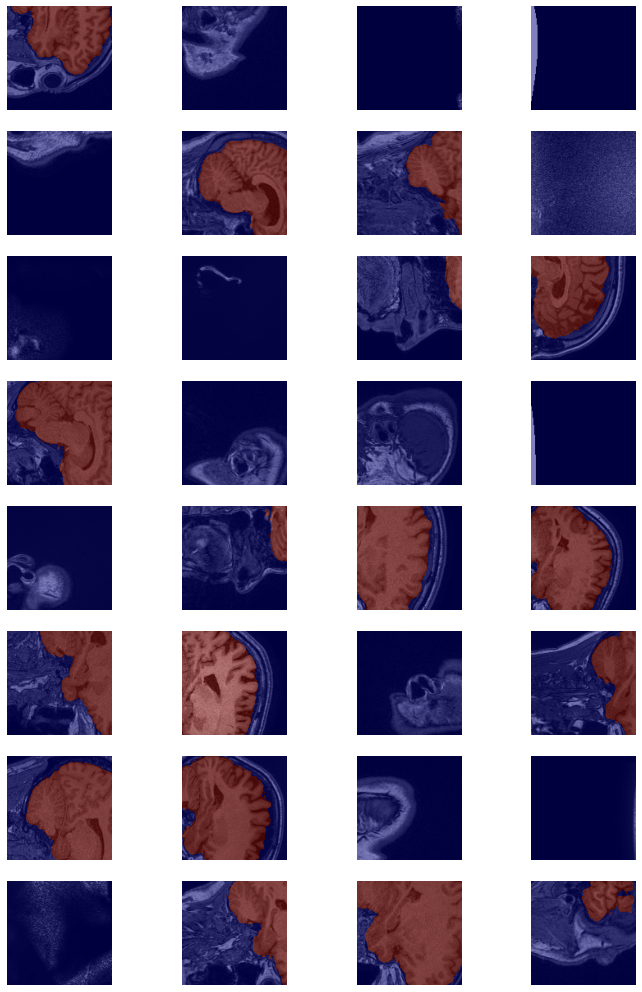

In [4]:
X,Y = gen_val.__getitem__(3)
print(X.min(),X.max())
Y = Y > 0.5
plt.figure(figsize = (12,18))
for ii in range(batch_size):
    plt.subplot(8, 4, ii+1)
    plt.imshow(X[ii,:,:,0], cmap = "gray")
    plt.axis("off")
    plt.imshow(Y[ii,:,:,0], cmap='jet', alpha=0.5, interpolation='none')
    plt.axis("off")
plt.show()

In [5]:
model = unet(input_shape=(128, 128, 1))
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       activation[0][0]                 
______________________________________________________________________________________________

In [6]:
model_name = "unet_ss.h5"

early_stop = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss', patience = 10)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')


def scheduler(epoch, lr):
    if epoch%5 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss= dice_coef_loss,
              metrics=[dice_coef])

history = model.fit(gen_train, epochs=100, verbose = 1, \
                       callbacks= [early_stop, monitor, lr_schedule], \
                       validation_data = (gen_val))

Epoch 1/100
721/721 [==============================] - 504s 545ms/step - loss: -0.7718 - dice_coef: 0.7718 - val_loss: -0.9533 - val_dice_coef: 0.9533
Epoch 2/100
721/721 [==============================] - 166s 230ms/step - loss: -0.9736 - dice_coef: 0.9736 - val_loss: -0.9618 - val_dice_coef: 0.9618
Epoch 3/100
721/721 [==============================] - 234s 325ms/step - loss: -0.9810 - dice_coef: 0.9810 - val_loss: -0.9721 - val_dice_coef: 0.9721
Epoch 4/100
721/721 [==============================] - 206s 286ms/step - loss: -0.9805 - dice_coef: 0.9805 - val_loss: -0.9698 - val_dice_coef: 0.9698
Epoch 5/100
 65/721 [=>............................] - ETA: 2:20 - loss: -0.9746 - dice_coef: 0.9746

KeyboardInterrupt: 

In [ ]:
import nibabel as nib
test_image = "C:\\Users\\rober\\OneDrive\\Documents\\Datasets\\CC359\\Original\\CC0014_philips_15_62_F.nii.gz"
data = nib.load(test_image)
affine = data.affine
data = data.get_fdata()
print(data.shape)

In [ ]:
#data = (data - data.min())/(data.max() - data.min())
model = unet(input_shape=(None, None, 1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss= dice_coef_loss,
              metrics=[dice_coef])

model.load_weights(model_name)

mask = model.predict(data[:,:,:,np.newaxis])[:,:,:,0]

In [ ]:
nifti = nib.Nifti1Image((mask > 0.5).astype(int), affine)
nib.save(nifti, "teste.nii")

In [ ]:
print(mask.shape)
plt.figure()
plt.imshow(mask[75])
plt.show()